In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
from datetime import datetime
from datetime import date
import math

In [20]:
df_visitor_log = pd.read_csv('/content/drive/MyDrive/Analytics Vidya Job-A-Thon/June/data/VisitorLogsData.csv')
df_visitor_log.head()

,webClientID,VisitDateTime,ProductID,UserID,Activity,Browser,OS,City,Country
0,WI10000050298,2018-05-07 04:28:45.970,pr100631,NaN,NaN,Chrome Mobile,Android,Chennai,India
1,WI10000025922,2018-05-13 07:26:04.964,pr100707,NaN,NaN,Chrome,Windows,NaN,Taiwan
2,WI100000204522,2018-05-11 11:43:42.832,pr100030,NaN,click,Chrome,windows,Gurgaon,India
3,WI10000011974,2018-05-13 15:20:23.436,Pr100192,NaN,CLICK,Chrome,Windows,,
4,WI100000441953,2018-05-08 20:44:25.238,Pr100762,NaN,click,Chrome,mac os x,Iselin,United States


In [21]:
df_users = pd.read_csv('/content/drive/MyDrive/Analytics Vidya Job-A-Thon/June/data/userTable.csv')
df_users.head()

,UserID,Signup Date,User Segment
0,U133159,2018-04-14 07:01:16.202607+00:00,C
1,U129368,2017-12-02 09:38:41.584270+00:00,B
2,U109654,2013-03-19 11:38:55+00:00,B
3,U108998,2018-01-18 08:29:51.627954+00:00,C
4,U131393,2018-03-27 08:05:28.806800+00:00,B


In [22]:
userNan = df_visitor_log.loc[df_visitor_log.UserID.isna()].webClientID.unique()
userNan

array(['WI10000050298', 'WI10000025922', 'WI100000204522', ...,
       'WI100000809055', 'WI100000995218', 'WI100000317971'], dtype=object)

In [23]:
webActivity = df_visitor_log.loc[df_visitor_log.webClientID.isin(userNan)]
webActivity

,webClientID,VisitDateTime,ProductID,UserID,Activity,Browser,OS,City,Country
0,WI10000050298,2018-05-07 04:28:45.970,pr100631,NaN,NaN,Chrome Mobile,Android,Chennai,India
1,WI10000025922,2018-05-13 07:26:04.964,pr100707,NaN,NaN,Chrome,Windows,NaN,Taiwan
2,WI100000204522,2018-05-11 11:43:42.832,pr100030,NaN,click,Chrome,windows,Gurgaon,India
3,WI10000011974,2018-05-13 15:20:23.436,Pr100192,NaN,CLICK,Chrome,Windows,,
4,WI100000441953,2018-05-08 20:44:25.238,Pr100762,NaN,click,Chrome,mac os x,Iselin,United States
...,...,...,...,...,...,...,...,...,...
6587995,WI100000406653,2018-05-21 07:14:03.231,pr100008,NaN,pageload,Chrome,Windows,NaN,NaN
6587996,WI100000159562,2018-05-25 09:13:04.011,Pr100307,NaN,click,Chrome,Windows,NaN,France
6587997,WI100000215596,NaN,Pr100147,NaN,NaN,Chrome,Windows,Durgapur,India
6587998,WI100000174318,2018-05-20 12:09:35.347,pr100728,NaN,pageload,Chrome Mobile,Android,Coimbatore,India


In [24]:
webActivity.loc[webActivity.UserID.notna()]

,webClientID,VisitDateTime,ProductID,UserID,Activity,Browser,OS,City,Country


In [25]:
df_visitor_log = df_visitor_log.loc[df_visitor_log.UserID.notna()]

In [26]:
df_visitor_log.OS = df_visitor_log.OS.map(lambda x: x.upper() if isinstance(x, str) else x)
df_visitor_log.ProductID = df_visitor_log.ProductID.map(lambda x: x.upper() if isinstance(x, str) else x)
df_visitor_log.Activity = df_visitor_log.Activity.map(lambda x: x.upper() if isinstance(x, str) else x)

In [27]:
df_visitor_log.shape

(650695, 9)

In [28]:
df_users.shape

(34050, 3)

## Steps to follow
#### Create required dataset
#### EDA
#### Feature Engineering
#### Time series analysis

## Creating required dataset

In the current case, you are supposed to generate an input feature set as on 28-May-2018. So, the visitor table is from 07-May-2018 to 27-May-2018.

In [29]:
def unixToDateTime(timestamp):
  if isinstance(timestamp, int):
    return datetime.utcfromtimestamp(timestamp/1e9).strftime('%Y-%m-%d %H:%M:%S')
  # elif 
  return timestamp

In [30]:
df_visitor_log['VisitDateTime'] = df_visitor_log['VisitDateTime'].apply(lambda x: unixToDateTime(x))
df_visitor_log.head()

,webClientID,VisitDateTime,ProductID,UserID,Activity,Browser,OS,City,Country
14,WI100000112772,1526366895249000000,PR100017,U106593,CLICK,Chrome Mobile,ANDROID,,
21,WI1000009977,1527058921790000000,PR101008,U108297,NaN,Chrome Mobile,ANDROID,Delhi,India
23,WI100000223826,2018-05-10 06:28:53.391,PR100241,U132443,NaN,Firefox,WINDOWS,NaN,India
24,WI10000021998,2018-05-08 12:40:02.153,PR100495,U134616,CLICK,Chrome,WINDOWS,Cottage Grove,United States
33,WI10000036281,2018-05-11 15:35:43.689,PR100363,U130784,CLICK,Chrome,CHROME OS,New Delhi,India


In [31]:
df_filtered_log = df_visitor_log[(df_visitor_log['VisitDateTime'] >= '2018-05-07') 
  & (df_visitor_log['VisitDateTime'] <= '2018-05-28')
  & (df_visitor_log['UserID'].notnull())]
df_filtered_log.head()

,webClientID,VisitDateTime,ProductID,UserID,Activity,Browser,OS,City,Country
23,WI100000223826,2018-05-10 06:28:53.391,PR100241,U132443,NaN,Firefox,WINDOWS,NaN,India
24,WI10000021998,2018-05-08 12:40:02.153,PR100495,U134616,CLICK,Chrome,WINDOWS,Cottage Grove,United States
33,WI10000036281,2018-05-11 15:35:43.689,PR100363,U130784,CLICK,Chrome,CHROME OS,New Delhi,India
50,WI100000110130,2018-05-19 00:02:31.347,PR100340,U120983,CLICK,Chrome,WINDOWS,Mumbai,India
54,WI10000014616,2018-05-19 04:51:45.337,PR100166,U120287,CLICK,Chrome,WINDOWS,NaN,NaN


In [32]:
df_filtered_log.shape

(527141, 9)

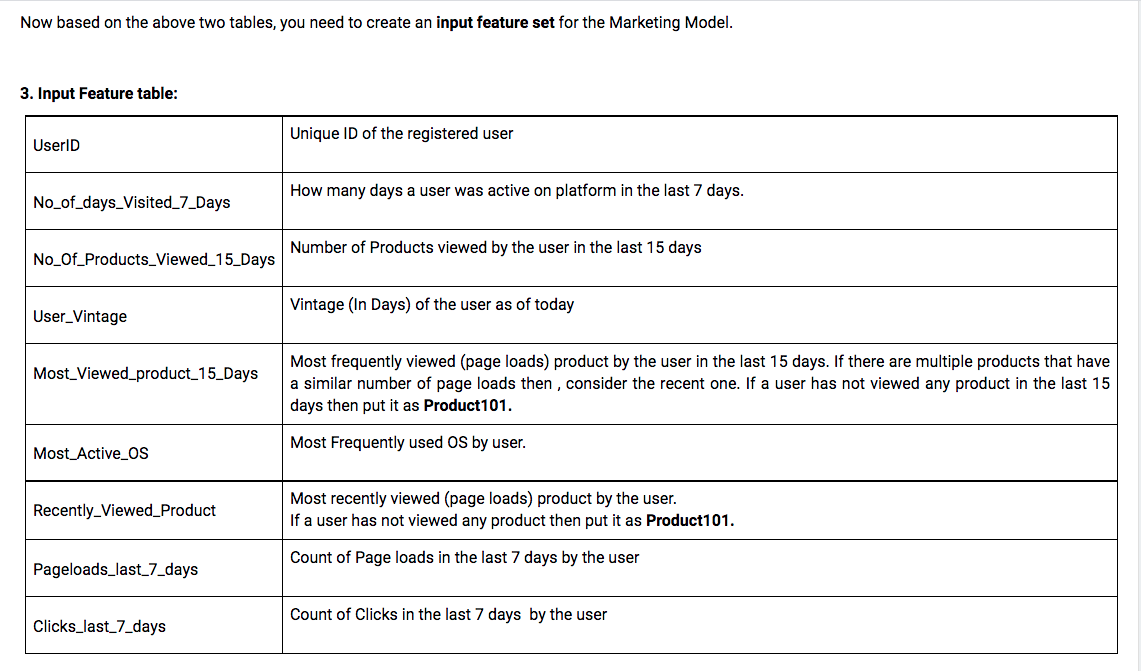

In [33]:
## check if case difference in UserID
len(df_filtered_log.UserID.unique())

32647

In [34]:
len(df_filtered_log.UserID.map(lambda x: x.upper()).unique())

32647

In [35]:
df_input_feature = pd.DataFrame(columns= ['UserID',
                                          'No_of_days_Visited_7_Days',
                                          'No_Of_Products_Viewed_15_Days',
                                          'User_Vintage',
                                          'Most_Viewed_product_15_Days',
                                          'Most_Active_OS',
                                          'Recently_Viewed_Product',
                                          'Pageloads_last_7_days',
                                          'Clicks_last_7_days'])

In [36]:
def createUserInputFeature(userID, signup, segment, df_input_feature):
  user_log = df_filtered_log.loc[df_filtered_log['UserID'] == userID]
  #Nan activity should be page load when user is opening product on first time
  user_log.Activity = user_log.Activity.fillna('PAGELOAD')

  productViewCount = user_log.ProductID.value_counts()
  mostViewedProduct = productViewCount.index[0] if len(productViewCount) > 0 else 'Product101' 
  user_log.ProductID = user_log.ProductID.fillna(mostViewedProduct)

  user_log['VisitDate'] = user_log.VisitDateTime.apply(lambda x: x.split(' ')[0] if isinstance(x, str) else x)
  logDateCount = user_log.VisitDate.value_counts()
  if len(logDateCount) > 0:
    user_log['VisitDateTime'] = user_log['VisitDateTime'].fillna(user_log.VisitDate.value_counts().index[0] + ' 05:30:00.000')
  
  last7Days = user_log.loc[user_log.VisitDateTime >= '2018-05-21']
  daysVisitedInLast7 = len(last7Days.VisitDateTime.map(lambda x: x.split(' ')[0]).unique())
  last15Days = user_log.loc[user_log.VisitDateTime >= '2018-05-13']
  last15DaysProduct = len(last15Days.ProductID.unique())
  signup = signup.split(' ')[0].split('-')
  vintage = (date(2018, 5, 28) - date(int(signup[0]), int(signup[1]), int(signup[2]))).days
  pageLoadProduts = last15Days.loc[last15Days.Activity == 'PAGELOAD']
  viewedProducts = pageLoadProduts['ProductID'].value_counts()
  mostViewed = 'Product101'
  if len(viewedProducts) > 0:
    mostViewed = viewedProducts.index[0]
  # OS = user_log['OS'].value_counts()
  # mostActive = ''
  # if len(OS) > 0:
  #   mostActive = OS.index[0]
  pageLoads = user_log.loc[user_log.Activity == 'PAGELOAD']
  recentViewed = 'Product101'
  if len(pageLoads) > 0:
    pageLoads.sort_values(by = 'VisitDateTime', ascending=False, inplace=True)
    recentViewed = pageLoads.iloc[0].ProductID
  
  return {
      'UserID': userID,
      'No_of_days_Visited_7_Days': daysVisitedInLast7,
      'No_Of_Products_Viewed_15_Days': last15DaysProduct,
      'User_Vintage': vintage,
      'Most_Viewed_product_15_Days': mostViewed,
      'Most_Active_OS': user_log.OS.value_counts().index[0] if len(user_log) > 0 else '',
      'Recently_Viewed_Product': recentViewed,
      'Pageloads_last_7_days': len(last7Days.loc[last7Days.Activity == 'PAGELOAD']),
      'Clicks_last_7_days': len(last7Days.loc[last7Days.Activity == 'CLICK'])
  }

In [37]:
# userData = df_users.iloc[14]
# row = createUserInputFeature(userData.UserID, userData['Signup Date'], userData['User Segment'], df_input_feature)
# df_input_feature = df_input_feature.append(row, ignore_index=True)

In [38]:
for i in range(len(df_users)):
  print(i)
  userData = df_users.iloc[i]
  row = createUserInputFeature(userData.UserID, userData['Signup Date'], userData['User Segment'], df_input_feature)
  df_input_feature = df_input_feature.append(row, ignore_index=True)
  

0
1
2
3


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

4
5
6
7
8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Streaming output truncated to the last 5000 lines.
29050
29051
29052
29053
29054
29055
29056
29057
29058
29059
29060
29061
29062
29063
29064
29065
29066
29067
29068
29069
29070
29071
29072
29073
29074
29075
29076
29077
29078
29079
29080
29081
29082
29083
29084
29085
29086
29087
29088
29089
29090
29091
29092
29093
29094
29095
29096
29097
29098
29099
29100
29101
29102
29103
29104
29105
29106
29107
29108
29109
29110
29111
29112
29113
29114
29115
29116
29117
29118
29119
29120
29121
29122
29123
29124
29125
29126
29127
29128
29129
29130
29131
29132
29133
29134
29135
29136
29137
29138
29139
29140
29141
29142
29143
29144
29145
29146
29147
29148
29149
29150
29151
29152
29153
29154
29155
29156
29157
29158
29159
29160
29161
29162
29163
29164
29165
29166
29167
29168
29169
29170
29171
29172
29173
29174
29175
29176
29177
29178
29179
29180
29181
29182
29183
29184
29185
29186
29187
29188
29189
29190
29191
29192
29193
29194
29195
29196
29197
29198
29199
29200
29201
29202
29203
29204
29205
29206
29207
2

In [39]:
df_input_feature.head()

,UserID,No_of_days_Visited_7_Days,No_Of_Products_Viewed_15_Days,User_Vintage,Most_Viewed_product_15_Days,Most_Active_OS,Recently_Viewed_Product,Pageloads_last_7_days,Clicks_last_7_days
0,U133159,0,0,44,Product101,ANDROID,PR100319,0,0
1,U129368,0,1,177,PR100071,WINDOWS,PR100071,0,0
2,U109654,0,1,1896,PR100102,WINDOWS,PR100102,0,0
3,U108998,1,1,130,PR100527,WINDOWS,PR100527,1,0
4,U131393,0,0,62,Product101,ANDROID,PR100201,0,0


In [40]:
df_input_feature.shape

(34050, 9)

In [41]:
df_input_feature.sort_values(by = 'UserID').to_csv('submission.csv', index = False)